# ConvNet + Unet++

1) load a data for a test
2) update a loop for test
3) for each epoch display a training loss , validation loss and test loss + ssim value also

# Data Loading

## Train

In [1]:
X_train_path = '/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42487393/seismic_w_noise_vol_42487393.npy'
y_train_path = '/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42487393/seismicCubes_RFC_fullstack_2024.42487393.npy'

## Test

In [2]:
X_test_path = '/home/simlab120/Denoise_comp/Pragyant/image-impeccable-test-data/2024-06-10_0d6402b1/seismic_w_noise_vol_44319345.npy'
y_test_path = '/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42487919/seismicCubes_RFC_fullstack_2024.42487919.npy'

## Valid

In [3]:
X_valid_path = '/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42502775/seismic_w_noise_vol_42502775.npy'
y_valid_path = '/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42502775/seismicCubes_RFC_fullstack_2024.42502775.npy'

In [4]:
shape = (1259,300,300)
# load the data
# make the data in 2d section
# make the train set and test set
# print the image also

In [5]:
import os
import pandas as pd
import numpy as np
from torchvision.io import read_image
from torch.utils.data import Dataset,DataLoader
import torch
# 2 files
# 1259*300*300 ---> 1259*300 in 300 images
# x,y load
# x,y sub sample
# pair
# return
class volDataset(Dataset):
    def __init__(self, x_slices, y_slices, transform=None):
        """
        x_slices: List of noisy seismic slices (each of shape 1259x300)
        y_slices: List of clean seismic slices (each of shape 1259x300)
        """
        self.x_slices = x_slices
        self.y_slices = y_slices
        self.transform = transform

    def __len__(self):
        return len(self.x_slices)

    def __getitem__(self, idx):
        """Returns one slice (1, 1259, 300)"""
        x_slice = torch.tensor(self.x_slices[idx], dtype=torch.float32).unsqueeze(0)  # (1, 1259, 300)
        y_slice = torch.tensor(self.y_slices[idx], dtype=torch.float32).unsqueeze(0)  # (1, 1259, 300)

        if self.transform:
            x_slice = self.transform(x_slice)
            y_slice = self.transform(y_slice)

        return x_slice, y_slice

In [6]:
from sklearn.model_selection import train_test_split
# Convert volume to 2D slices
# Load seismic volumes
X_volume = np.load('/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42487393/seismic_w_noise_vol_42487393.npy',allow_pickle=True)  # (1259, 300, 300)
y_volume = np.load('/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42487393/seismicCubes_RFC_fullstack_2024.42487393.npy',allow_pickle=True)  # (1259, 300, 300)

X_volume_t = np.load(X_test_path,allow_pickle=True)
y_volume_t = np.load(y_test_path,allow_pickle=True)

X_volume_v = np.load(X_valid_path,allow_pickle=True)
y_volume_v = np.load(y_valid_path,allow_pickle=True)
# Convert volume to 2D slices

X_slices = [X_volume[:, :, i] for i in range(X_volume.shape[2])]  # List of 300 slices
y_slices = [y_volume[:, :, i] for i in range(y_volume.shape[2])]  # List of 300 slices

X_slices_t = [X_volume_t[:, :, i] for i in range(X_volume_t.shape[2])]
y_slices_t = [y_volume_t[:, :, i] for i in range(y_volume_t.shape[2])]

X_slices_v = [X_volume_v[:, :, i] for i in range(X_volume_v.shape[2])]
y_slices_v = [y_volume_v[:, :, i] for i in range(y_volume_v.shape[2])]

# Create datasets
train_dataset = volDataset(X_slices, y_slices)
valid_dataset = volDataset(X_slices_v,y_slices_v)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(valid_dataset,batch_size=8, shuffle=False)

# Check batch shapes
for x_batch, y_batch in train_loader:
    print("Train Batch Shape:", x_batch.shape, y_batch.shape)  # Expected: (8, 1, 1259, 300)
    break
for x_batch, y_batch in val_loader:
    print("valid Batch Shape:", x_batch.shape, y_batch.shape)  # Expected: (8, 1, 1259, 300)
    break

Train Batch Shape: torch.Size([8, 1, 1259, 300]) torch.Size([8, 1, 1259, 300])
valid Batch Shape: torch.Size([8, 1, 1259, 300]) torch.Size([8, 1, 1259, 300])


# Model

In [7]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [8]:
class Crop2d(nn.Module):
    def __init__(self, left=10, right=10, top=21, bottom=0):
        super(Crop2d, self).__init__()
        self.left = left
        self.right = right
        self.top = top
        self.bottom = bottom

    def forward(self, x):
        return x[:, :, self.top:x.shape[2] - self.bottom, self.left:x.shape[3] - self.right]

In [9]:
import timm
from segmentation_models_pytorch.decoders.unetplusplus import UnetPlusPlus

/home/simlab120/anaconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import convnext_large, ConvNeXt_Large_Weights

class UNetWithConvNeXtEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Load ConvNeXt Large with pretrained weights
        weights = ConvNeXt_Large_Weights.IMAGENET1K_V1
        self.encoder = convnext_large(weights=weights)
        
        # Convert grayscale (1 channel) to RGB (3 channels)
        self.input_adapter = nn.Conv2d(1, 3, kernel_size=1)

        # Get the number of output channels from the last ConvNeXt block
        encoder_out_channels = 1536  # ConvNeXt Large last block output

        # Decoder part (Upsampling layers)
        # Decoder part (Upsampling layers)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(768, 384, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(384, 192, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(192, 96, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(96, 64, kernel_size=2, stride=2), nn.ReLU()
        )

        # Final 1x1 convolution to produce a single-channel grayscale output
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Convert grayscale to 3-channel input
        x = self.input_adapter(x)

        # Extract features from ConvNeXt encoder
        e1 = self.encoder.features[0](x)   # Stem
        #print(f"e1 shape: {e1.shape}")
        e2 = self.encoder.features[1](e1)
        #print(f"e2 shape: {e2.shape}")  # Stage 1
        e3 = self.encoder.features[2](e2)
        #print(f"e3 shape: {e3.shape}")   # Stage 2
        e4 = self.encoder.features[3](e3)  # Stage 3
        #print(f"e4 shape: {e4.shape}")
        e5 = self.encoder.features[4](e4)  # Stage 4 (Final output from encoder)
        #print(f"Shape after encoder: {e5.shape}")  # Should be (batch, 1536, H/32, W/32)

        # Decoder (upsampling)
        d = self.decoder(e5)

        # Interpolate to match original input size
        d = F.interpolate(d, size=x.shape[2:], mode="bilinear", align_corners=False)

        # Final convolution
        d = self.final_conv(d)

        #print(f"Shape after decoder: {d.shape}")  # Should match input spatial dimensions

        return d

# Example usage
model = UNetWithConvNeXtEncoder()
x = torch.randn(1, 1, 1259, 300)  # Example grayscale input
out = model(x)
print(out.shape)  # Should match (1, 1, 1259, 300)


torch.Size([1, 1, 1259, 300])


In [11]:
pip install torcheval

Note: you may need to restart the kernel to use updated packages.


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define model
model = UNetWithConvNeXtEncoder()

# Define Loss Function (MSE for denoising)
criterion = nn.MSELoss()

# Define Optimizer (Adam works well)
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [13]:
# Check batch shapes
for x_batch, y_batch in train_loader:
    print("Train Batch Shape:", x_batch.shape, y_batch.shape)  # Expected: (batch_size, 1, 1259, 300)
    break

Train Batch Shape: torch.Size([8, 1, 1259, 300]) torch.Size([8, 1, 1259, 300])


In [14]:
from torchmetrics import StructuralSimilarityIndexMeasure
ssim_metric = StructuralSimilarityIndexMeasure()

/home/simlab120/anaconda3/envs/torch/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


In [15]:
import matplotlib.pyplot as plt

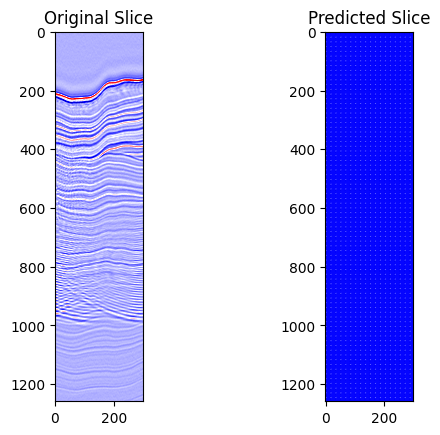

Epoch [1/200], Train Loss: 694189643.4295, Train SSIM: 0.2660,           Val Loss: 17461.7765, Val SSIM: 0.3530


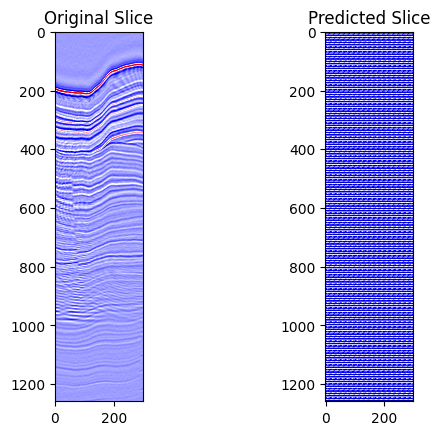

Epoch [2/200], Train Loss: 11894.2258, Train SSIM: 0.4394,           Val Loss: 10089.3770, Val SSIM: 0.4147


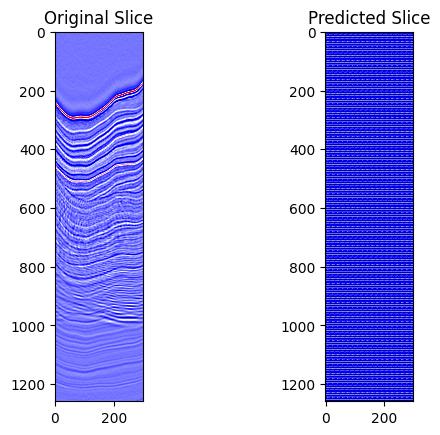

Epoch [3/200], Train Loss: 10070.6797, Train SSIM: 0.4725,           Val Loss: 10089.1584, Val SSIM: 0.4149


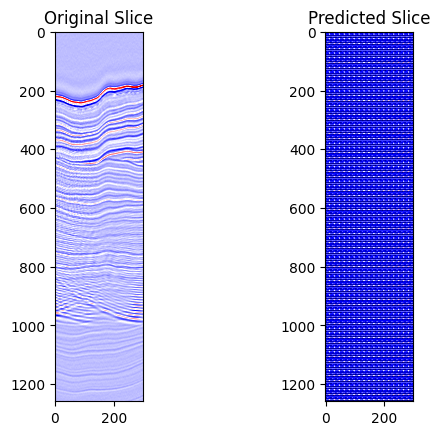

Epoch [4/200], Train Loss: 10074.2473, Train SSIM: 0.4731,           Val Loss: 10088.9248, Val SSIM: 0.4152


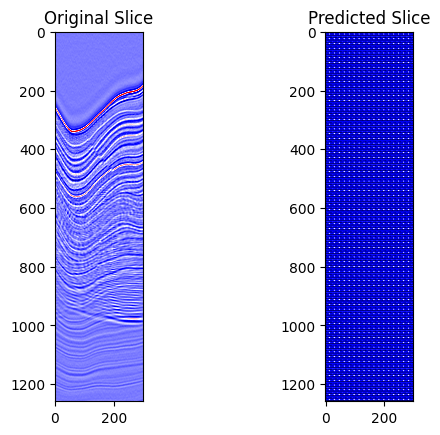

Epoch [5/200], Train Loss: 10076.7523, Train SSIM: 0.4721,           Val Loss: 10088.7580, Val SSIM: 0.4154


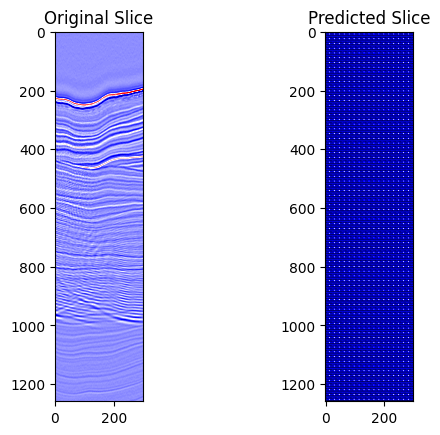

Epoch [6/200], Train Loss: 10064.8099, Train SSIM: 0.4724,           Val Loss: 10088.6249, Val SSIM: 0.4156


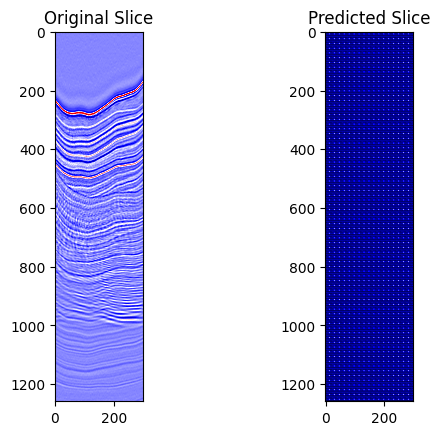

Epoch [7/200], Train Loss: 10083.7624, Train SSIM: 0.4734,           Val Loss: 10088.5181, Val SSIM: 0.4157


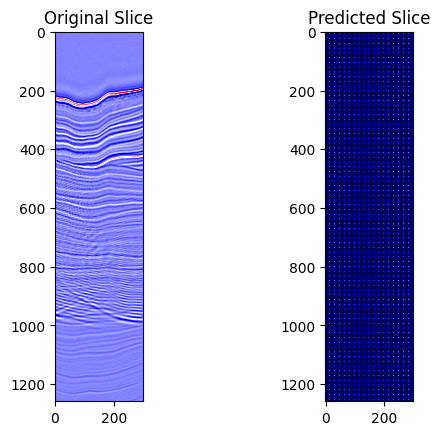

Epoch [8/200], Train Loss: 10079.1647, Train SSIM: 0.4741,           Val Loss: 10088.4399, Val SSIM: 0.4158


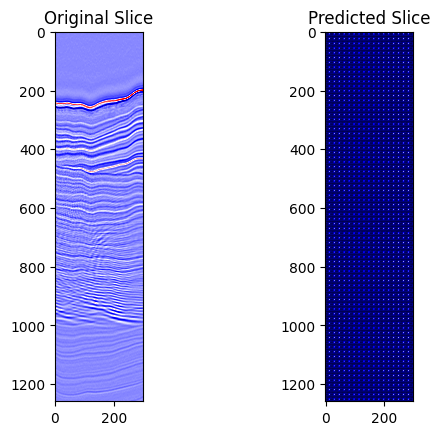

Epoch [9/200], Train Loss: 10066.0583, Train SSIM: 0.4737,           Val Loss: 10088.3858, Val SSIM: 0.4159


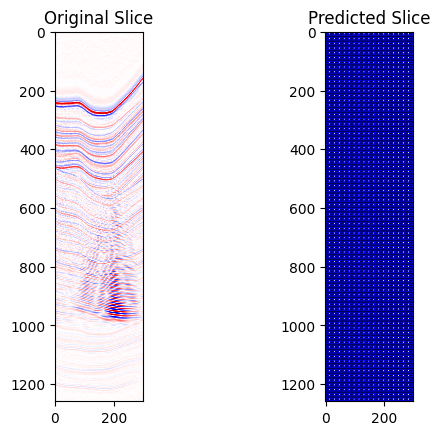

Epoch [10/200], Train Loss: 10070.5664, Train SSIM: 0.4733,           Val Loss: 10088.3498, Val SSIM: 0.4159


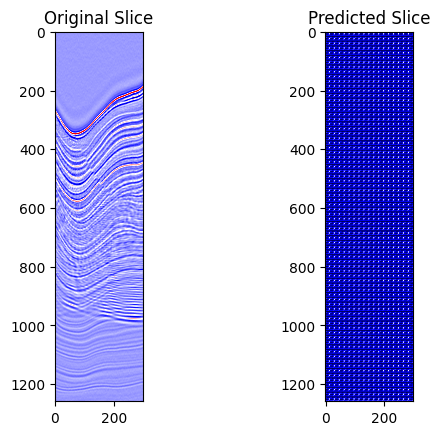

Epoch [11/200], Train Loss: 10078.2517, Train SSIM: 0.4745,           Val Loss: 10088.3291, Val SSIM: 0.4160


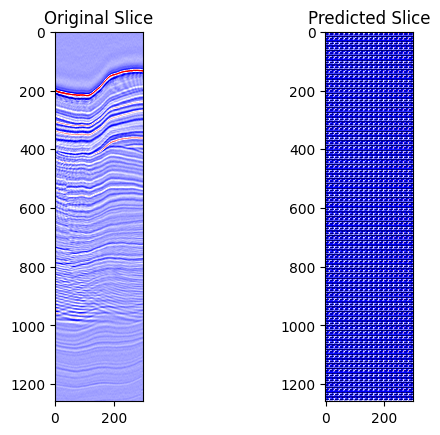

Epoch [12/200], Train Loss: 10074.7474, Train SSIM: 0.4736,           Val Loss: 10088.3169, Val SSIM: 0.4160


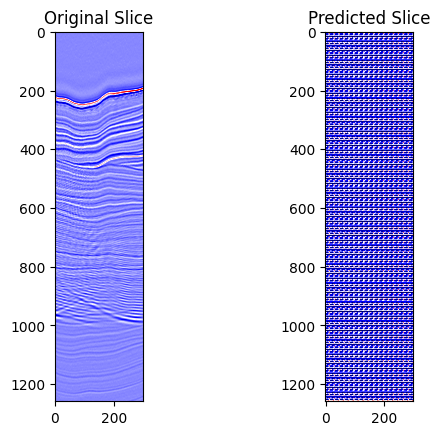

Epoch [13/200], Train Loss: 10070.3421, Train SSIM: 0.4746,           Val Loss: 10088.3114, Val SSIM: 0.4161


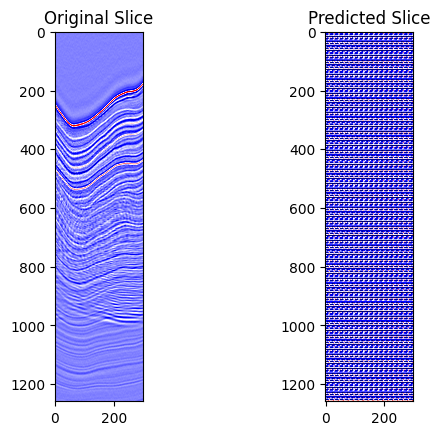

Epoch [14/200], Train Loss: 10062.5448, Train SSIM: 0.4727,           Val Loss: 10088.3100, Val SSIM: 0.4161


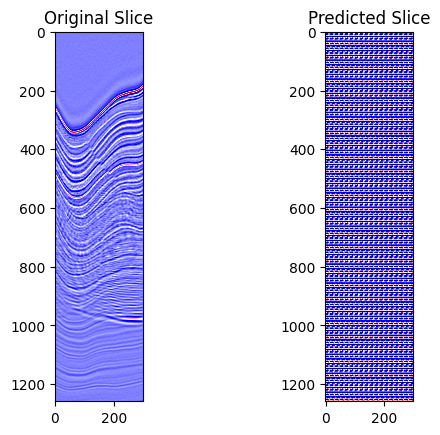

Epoch [15/200], Train Loss: 10080.6547, Train SSIM: 0.4730,           Val Loss: 10088.3102, Val SSIM: 0.4161


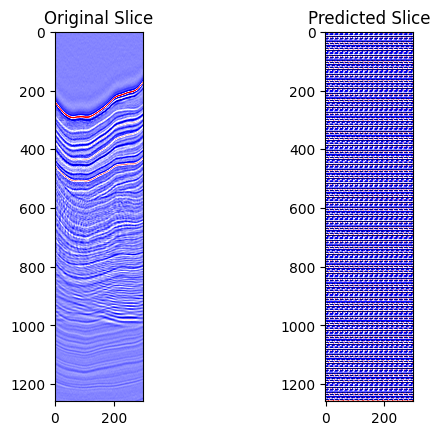

Epoch [16/200], Train Loss: 10071.0471, Train SSIM: 0.4732,           Val Loss: 10088.3124, Val SSIM: 0.4161


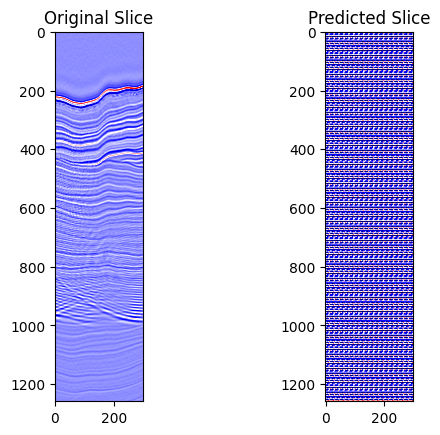

Epoch [17/200], Train Loss: 10072.1389, Train SSIM: 0.4733,           Val Loss: 10088.3143, Val SSIM: 0.4161


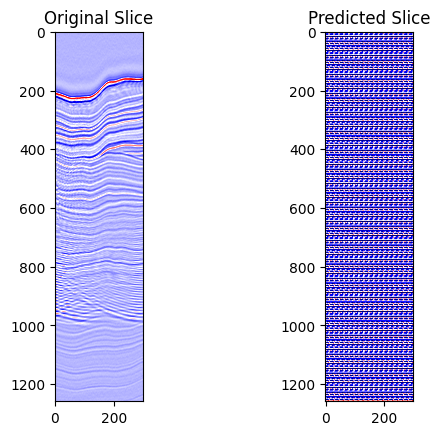

Epoch [18/200], Train Loss: 10065.4905, Train SSIM: 0.4733,           Val Loss: 10088.3166, Val SSIM: 0.4161


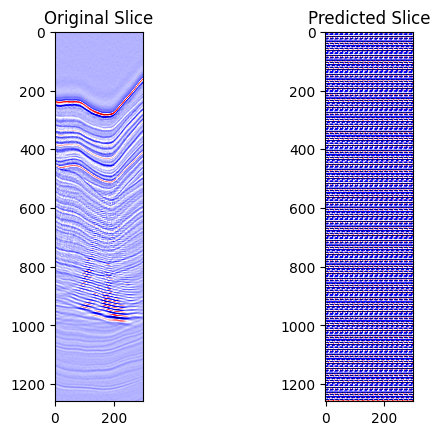

Epoch [19/200], Train Loss: 10079.0860, Train SSIM: 0.4738,           Val Loss: 10088.3179, Val SSIM: 0.4161


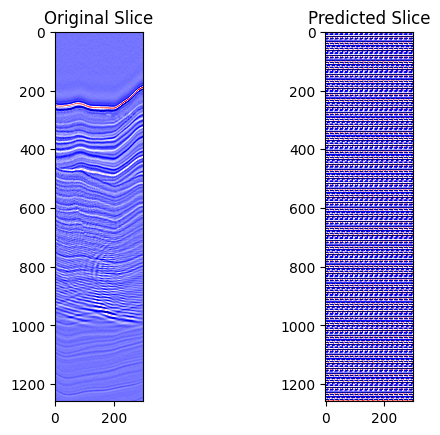

Epoch [20/200], Train Loss: 10065.2397, Train SSIM: 0.4748,           Val Loss: 10088.3194, Val SSIM: 0.4161


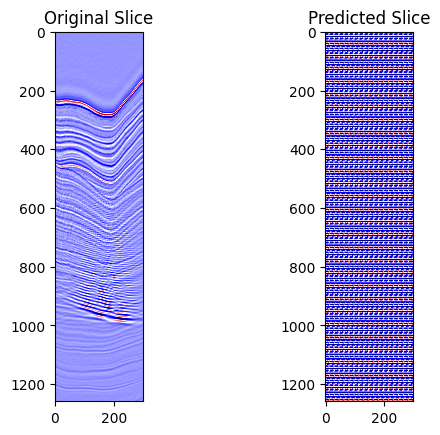

Epoch [21/200], Train Loss: 10078.3622, Train SSIM: 0.4738,           Val Loss: 10088.3200, Val SSIM: 0.4161


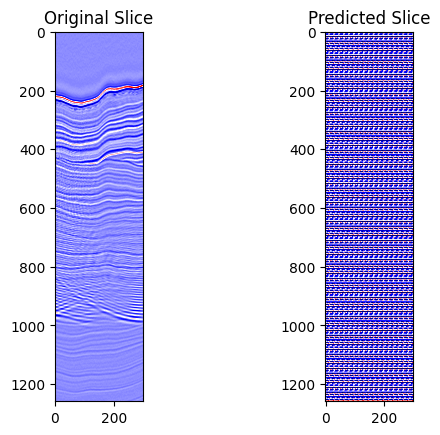

Epoch [22/200], Train Loss: 10076.4933, Train SSIM: 0.4735,           Val Loss: 10088.3204, Val SSIM: 0.4161


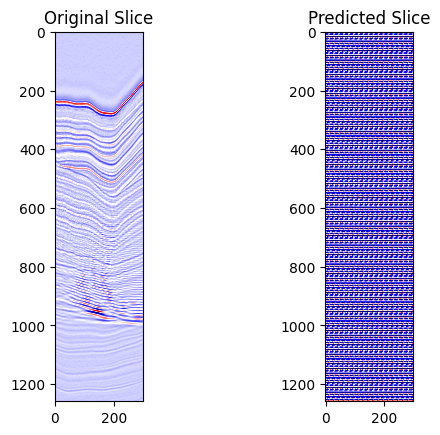

Epoch [23/200], Train Loss: 10074.5462, Train SSIM: 0.4752,           Val Loss: 10088.3212, Val SSIM: 0.4161


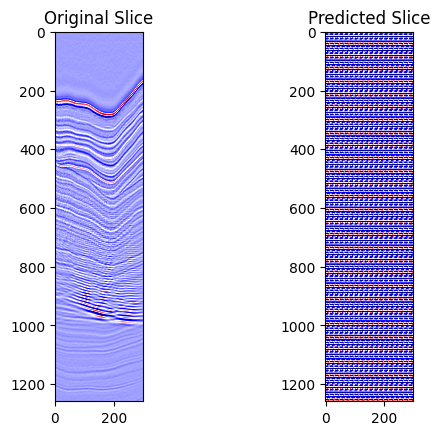

Epoch [24/200], Train Loss: 10077.0334, Train SSIM: 0.4743,           Val Loss: 10088.3222, Val SSIM: 0.4161


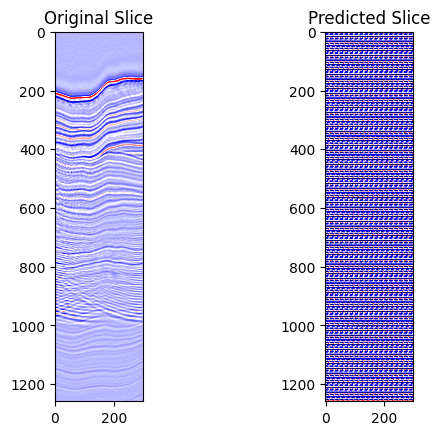

Epoch [25/200], Train Loss: 10067.9896, Train SSIM: 0.4741,           Val Loss: 10088.3223, Val SSIM: 0.4161


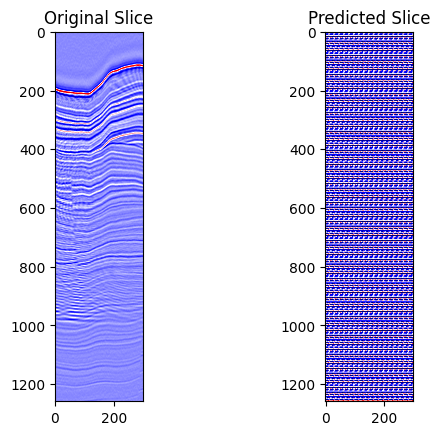

Epoch [26/200], Train Loss: 10077.0380, Train SSIM: 0.4738,           Val Loss: 10088.3229, Val SSIM: 0.4161


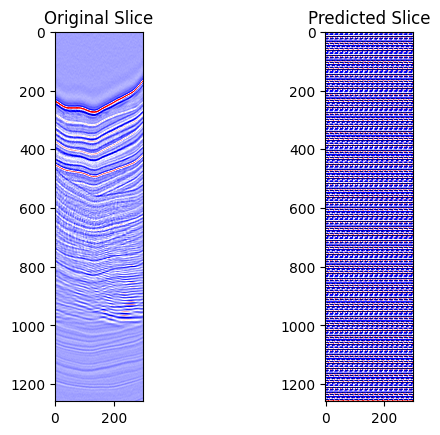

Epoch [27/200], Train Loss: 10072.6816, Train SSIM: 0.4738,           Val Loss: 10088.3224, Val SSIM: 0.4161


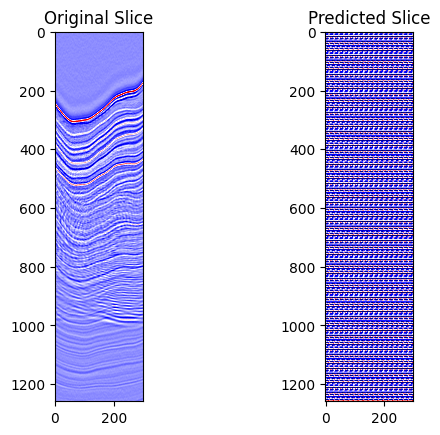

Epoch [28/200], Train Loss: 10061.5529, Train SSIM: 0.4740,           Val Loss: 10088.3220, Val SSIM: 0.4161


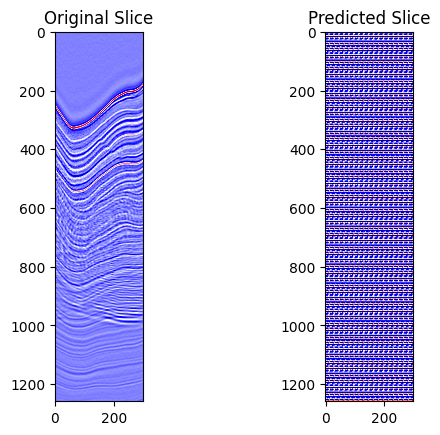

Epoch [29/200], Train Loss: 10062.7423, Train SSIM: 0.4740,           Val Loss: 10088.3216, Val SSIM: 0.4161


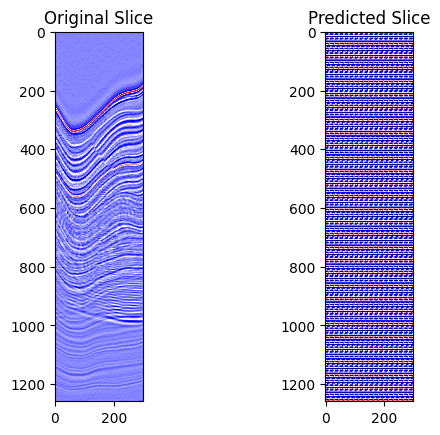

Epoch [30/200], Train Loss: 10071.3652, Train SSIM: 0.4748,           Val Loss: 10088.3222, Val SSIM: 0.4161


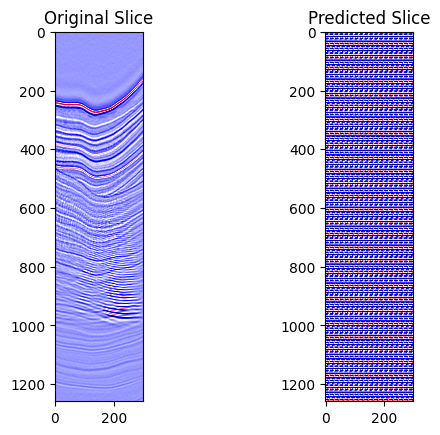

Epoch [31/200], Train Loss: 10073.8233, Train SSIM: 0.4736,           Val Loss: 10088.3216, Val SSIM: 0.4161


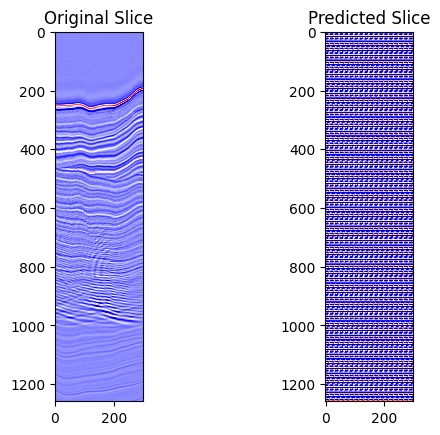

Epoch [32/200], Train Loss: 10064.7579, Train SSIM: 0.4739,           Val Loss: 10088.3222, Val SSIM: 0.4161


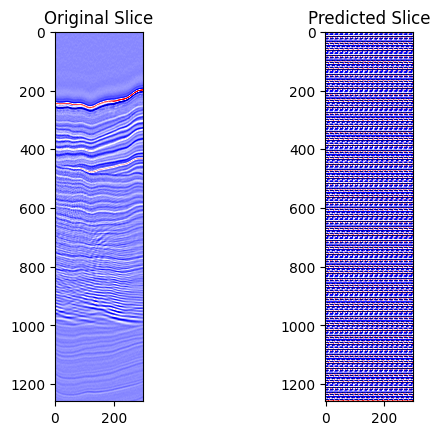

Epoch [33/200], Train Loss: 10061.9254, Train SSIM: 0.4731,           Val Loss: 10088.3214, Val SSIM: 0.4161


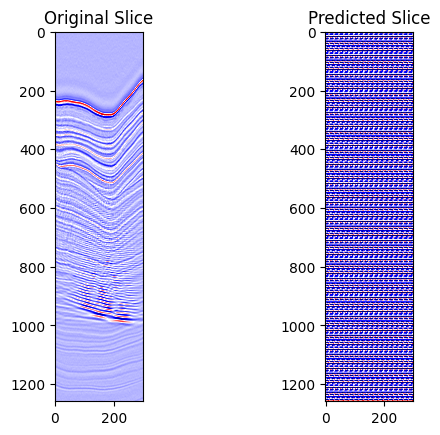

Epoch [34/200], Train Loss: 10073.7707, Train SSIM: 0.4724,           Val Loss: 10088.3221, Val SSIM: 0.4161


In [ ]:
# Number of epochs
num_epochs = 200

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_ssim = 0.0

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch_ssim = ssim_metric(outputs.detach(), y_batch.detach())
        running_ssim += batch_ssim.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_ssim = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            val_outputs = model(x_val)
            val_loss += criterion(val_outputs, y_val).item()
            val_ssim += ssim_metric(val_outputs, y_val).item()

    # Prediction on a single slice from X_slices_t
    random_slice = X_slices_t[torch.randint(0, len(X_slices_t), (1,)).item()]

    # Convert to PyTorch tensor and add batch and channel dimensions
    random_slice = torch.tensor(random_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    prediction = model(random_slice).detach()

    # Visualize the original and predicted slice
    plt.subplot(1, 2, 1)
    plt.title("Original Slice")
    plt.imshow(random_slice.squeeze().cpu().numpy(), cmap='seismic')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Slice")
    plt.imshow(prediction.squeeze().cpu().numpy(), cmap='seismic')
    plt.show()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Train SSIM: {running_ssim / len(train_loader):.4f}, \
          Val Loss: {val_loss / len(val_loader):.4f}, Val SSIM: {val_ssim / len(val_loader):.4f}")


print("Training complete!")
